In [1]:
import sqlite3
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

/Users/hough/anaconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:278: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  'Matplotlib is building the font cache using fc-list. '


In [2]:
%matplotlib inline

In [3]:
# Create run_query function
def run_query(query):
    with sqlite3.connect('chinook.db') as conn:
        return pd.read_sql(query, conn)

In [4]:
# Create run_command function
def run_command(command):
    with sqlite3.connect('chinook.db') as conn:
        return conn.cursor().execute(command)

In [5]:
# Create show_tables function
def show_tables():
    return run_query("SELECT name, type FROM sqlite_master WHERE type IN ('table','view')")

In [6]:
show_tables()

,name,type
0,album,table
1,artist,table
2,customer,table
3,employee,table
4,genre,table
5,invoice,table
6,invoice_line,table
7,media_type,table
8,playlist,table
9,playlist_track,table


# Best selling record genres in the USA

In [7]:
q = '''
WITH usa_tracks AS
(
    SELECT g.name, il.track_id FROM genre AS g
    INNER JOIN track AS t ON t.genre_id = g.genre_id
    INNER JOIN invoice_line AS il ON il.track_id = t.track_id
    INNER JOIN invoice AS i ON i.invoice_id = il.invoice_id
    INNER JOIN customer AS c ON c.customer_id = i.customer_id
    WHERE c.country = "USA"
)


SELECT
    name AS genre,
    COUNT(track_id) AS no_tracks_sold,
    (CAST(COUNT(track_id) AS FLOAT) / (SELECT COUNT(track_id) FROM usa_tracks))*100 AS percent_tracks_sold
FROM usa_tracks
GROUP BY 1
'''
usa_tracks_sold_genre = run_query(q)
usa_tracks_sold_genre


,genre,no_tracks_sold,percent_tracks_sold
0,Alternative,35,3.330162
1,Alternative & Punk,130,12.369172
2,Blues,36,3.425309
3,Classical,4,0.380590
4,Easy Listening,13,1.236917
5,Electronica/Dance,5,0.475737
6,Heavy Metal,3,0.285442
7,Hip Hop/Rap,20,1.902950
8,Jazz,14,1.332065
9,Latin,22,2.093245


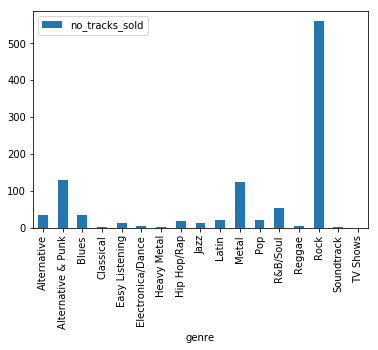

In [8]:
usa_genre_sold = usa_tracks_sold_genre[['genre', 'no_tracks_sold']].set_index('genre')
usa_genre_sold.plot.bar()

Rock is by far the most sold genre in the USA, followed by Alternative & Punk and then Metal. Other notable genres are R&B/Soul, Alternative, Blues and Pop.

Considering the list of artists and their genre's provided to me, I would recommend, in order from most recommended to least, Red Tone (Punk), Slim Jim Bites (Blues), and Meteor and the Girls (Pop). Regal (Hip Hop) gets left out as the other genres scored my highly than theirs.

# Employee performance

In [9]:
q = '''
SELECT
    (e.first_name || ' ' || e.last_name) AS employee_name, 
    e.hire_date, 
    e.country, 
    SUM(i.total) AS total_sales 
FROM employee AS e
INNER JOIN customer AS c ON c.support_rep_id = e.employee_id
INNER JOIN invoice AS i ON i.customer_id = c.customer_id
GROUP BY 1
'''
employee_sales = run_query(q)
employee_sales

,employee_name,hire_date,country,total_sales
0,Jane Peacock,2017-04-01 00:00:00,Canada,1731.51
1,Margaret Park,2017-05-03 00:00:00,Canada,1584.00
2,Steve Johnson,2017-10-17 00:00:00,Canada,1393.92


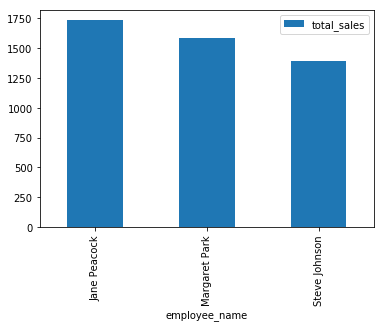

In [10]:
employee_sales[['employee_name', 'total_sales']].set_index('employee_name').plot.bar()

All employees have sold almost the same amount of records if we take into account the data they were hired as well.

# Sales by country

In [11]:
q = '''
WITH country_or_other AS (
    SELECT
        CASE
            WHEN (
                SELECT COUNT(*)
                FROM customer
                WHERE country = c.country
                ) = 1 THEN "Other"
                ELSE country
        END AS country,
        c.customer_id,
        i.*
    FROM customer AS c
    INNER JOIN invoice AS i ON i.customer_id = c.customer_id
)
SELECT
    country,
    total_customers,
    total_sales_val,
    mean_order_val,
    mean_customer_lifetime_val
FROM (
    SELECT
        country,
        COUNT(DISTINCT(customer_id)) AS total_customers,
        SUM(total) AS total_sales_val,
        SUM(total) / COUNT(invoice_id) AS mean_order_val,
        SUM(total) / COUNT(DISTINCT(customer_id)) AS mean_customer_lifetime_val,
        CASE
            WHEN country = "Other"
                THEN 1
                ELSE 0
        END AS sort
    FROM country_or_other AS c
    GROUP BY c.country
    ORDER BY sort ASC, total_sales_val DESC
)
'''

country_sales = run_query(q)
country_sales

,country,total_customers,total_sales_val,mean_order_val,mean_customer_lifetime_val
0,USA,13,1040.49,7.942672,80.037692
1,Canada,8,535.59,7.047237,66.948750
2,Brazil,5,427.68,7.011148,85.536000
3,France,5,389.07,7.781400,77.814000
4,Germany,4,334.62,8.161463,83.655000
5,Czech Republic,2,273.24,9.108000,136.620000
6,United Kingdom,3,245.52,8.768571,81.840000
7,Portugal,2,185.13,6.383793,92.565000
8,India,2,183.15,8.721429,91.575000
9,Other,15,1094.94,7.448571,72.996000


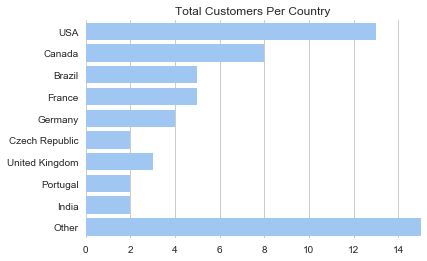

In [12]:
sns.set(style='whitegrid')

# Initialize the matplotlib figure
f, ax = plt.subplots()

# Plot the total crashes
sns.set_color_codes('pastel')
sns.barplot(x='total_customers', y='country', data=country_sales,
            label='Country Sales', color='b')

# Add a legend and informative axis label
ax.set_title('Total Customers Per Country')
ax.set(xlim=(0, 15), ylabel='', xlabel='')
sns.despine(left=True, bottom=True)

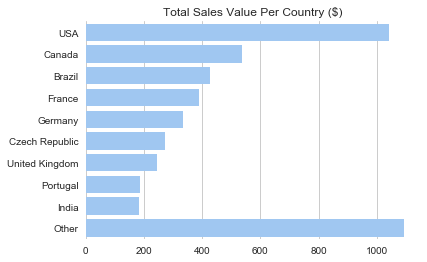

In [13]:
sns.set(style='whitegrid')

# Initialize the matplotlib figure
f, ax = plt.subplots()

# Plot the total crashes
sns.set_color_codes('pastel')
sns.barplot(x='total_sales_val', y='country', data=country_sales,
            label='Country Sales', color='b')

# Add a legend and informative axis label
ax.set_title('Total Sales Value Per Country ($)')
ax.set(xlim=(0,1150), ylabel='', xlabel='')
sns.despine(left=True, bottom=True)

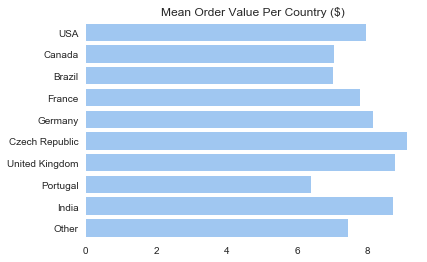

In [14]:
sns.set(style='white')

# Initialize the matplotlib figure
f, ax = plt.subplots()

# Plot the total crashes
sns.set_color_codes('pastel')
sns.barplot(x='mean_order_val', y='country', data=country_sales,
            label='Country Sales', color='b')

# Add a legend and informative axis label
ax.set_title('Mean Order Value Per Country ($)')
ax.set(xlim=(0,9.5), ylabel='', xlabel='')
sns.despine(left=True, bottom=True)

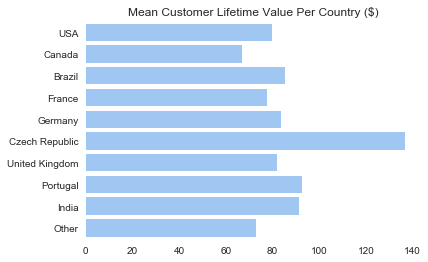

In [15]:
sns.set(style='white')

# Initialize the matplotlib figure
f, ax = plt.subplots()

# Plot the total crashes
sns.set_color_codes('pastel')
sns.barplot(x='mean_customer_lifetime_val', y='country', data=country_sales,
            label='Country Sales', color='b')

# Add a legend and informative axis label
ax.set_title('Mean Customer Lifetime Value Per Country ($)')
ax.set(ylabel='', xlabel='')
sns.despine(left=True, bottom=True)

Quite clearly, customers from the US far outweigh customers from all other countries. More interestingly however, are the columns comparing order values and amount spent per customer. The Czech Republic shows great potential for growth, with the highest mean order values and mean customer lifetime values. Other interesting prospects include Portugal, India, Brazil, and Germany.

# How customers purchase: album vs individual tracks

In [17]:
run_command('DROP VIEW album_track_counts')

c = '''
CREATE VIEW album_track_counts AS
    SELECT album_id, COUNT(*) AS album_tracks
    FROM track
    GROUP BY album_id;
'''
run_command(c)

q = '''
WITH yes_no_albums AS (
    SELECT
        CASE
            WHEN COUNT(t.track_id) = atc.album_tracks
                THEN 1
                ELSE 0
        END AS yes,
        CASE
            WHEN COUNT(t.track_id) != atc.album_tracks
                THEN 1
                ELSE 0
        END AS no
    FROM invoice AS i
    INNER JOIN invoice_line AS il ON il.invoice_id = i.invoice_id
    INNER JOIN track AS t ON t.track_id = il.track_id
    INNER JOIN album_track_counts AS atc ON atc.album_id = t.album_id
    GROUP BY i.invoice_id
)

SELECT
    SUM(yes) AS yes,
    SUM(no) AS no,
    (CAST(SUM(yes) AS FLOAT) / (SUM(yes) + SUM(no))) * 100 AS percent_yes,
    (CAST(SUM(no) AS FLOAT) / (SUM(yes) + SUM(no))) * 100 AS percent_no
FROM yes_no_albums;
'''

run_query(q)

,yes,no,percent_yes,percent_no
0,121,493,19.70684,80.29316


Most customers purchase individual tracks from albums instead of buying the full album. Despite this, almost 20% of customers still choose to purchase the full albums. By only buying the most popular tracks from each album, the record store would be losing almost 20% of their sales. This is not a good idea.